In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchsummary import summary
from torchvision.transforms import RandAugment
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import MultiStepLR

In [57]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [58]:
LABELS = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

In [59]:
data_dir = "/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py"

In [60]:
def load_cifar10_batches():
    data = []
    labels = []
    for i in range(1, 6):  # data_batch_1 to data_batch_5
        batch = unpickle(os.path.join(data_dir, f"data_batch_{i}"))
        data.append(batch[b"data"])
        labels += batch[b"labels"]
    # Reshape to (N, 3, 32, 32) and normalize pixel values to [0,1]
    data = np.vstack(data).reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    labels = np.array(labels)
    return data, labels

# Load training data
train_data, train_labels = load_cifar10_batches()

# Load test data (will be used for validation)
test_batch = unpickle(os.path.join(data_dir, "test_batch"))
test_data = test_batch[b"data"].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
test_labels = np.array(test_batch[b"labels"])

In [61]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy.ndarray): Array of images in shape (N, 3, 32, 32) with values in [0,1].
            labels (numpy.ndarray): Array of labels.
            transform (callable, optional): Transform to be applied on an image.
        """
        self.data = data
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Get image and label at the specified index
        image = self.data[idx]
        label = self.labels[idx]
        # Convert image (C, H, W) to (H, W, C) and then to PIL Image
        image = Image.fromarray(np.transpose((image * 255).astype(np.uint8), (1, 2, 0)))
        if self.transform:
            image = self.transform(image)
        return image, label

In [62]:
def show_sample_images(loader, classes, num_samples=4, title="Sample images"):
    """
    Displays a grid of sample images from the given data loader.
    """
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Denormalize images for visualization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    images = images.numpy().transpose((0, 2, 3, 1))
    images = std * images + mean
    images = np.clip(images, 0, 1)
    
    plt.figure(figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [63]:
def eda_dataset(dataset, classes):
    """
    Performs basic EDA on a dataset:
    - Plots class distribution
    - Returns distribution dictionary
    """
    # Get labels from the dataset (dataset.samples for ImageFolder or dataset.targets for CIFAR10)
    if hasattr(dataset, 'targets'):
        labels = dataset.targets
    elif hasattr(dataset, 'samples'):
        labels = [s[1] for s in dataset.samples]
    else:
        raise ValueError("Dataset type not supported for EDA")
    
    count_dict = Counter(labels)
    # Map numeric labels to class names (if available)
    count_named = {classes[k]: v for k, v in count_dict.items()}
    
    # Plot distribution
    plt.figure(figsize=(8,4))
    plt.bar(count_named.keys(), count_named.values())
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.title("Class distribution")
    plt.show()
    
    return count_named

In [64]:
def mixup_data(x, y, alpha=1.0):
    """
    Returns mixed inputs, pairs of targets, and lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [65]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [66]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding (no bias)"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


In [67]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, use_se=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

        self.use_se = use_se
        if self.use_se:
            self.se = SEBlock(planes * self.expansion)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.use_se:
            out = self.se(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [68]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, width_multiplier=1, use_se=True):
        super(ResNet, self).__init__()
        # Increase the initial number of channels by the width multiplier
        self.in_planes = 16 * width_multiplier

        # Initial convolution layer
        self.conv1 = conv3x3(3, 16 * width_multiplier)
        self.bn1 = nn.BatchNorm2d(16 * width_multiplier)
        self.relu = nn.ReLU(inplace=True)
        
        # Build layers; each stage multiplies the number of filters
        self.layer1 = self._make_layer(block, 16 * width_multiplier, num_blocks[0], stride=1, use_se=use_se)
        self.layer2 = self._make_layer(block, 32 * width_multiplier, num_blocks[1], stride=2, use_se=use_se)
        self.layer3 = self._make_layer(block, 64 * width_multiplier, num_blocks[2], stride=2, use_se=use_se)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * width_multiplier * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, use_se):
        layers = []
        # First block in the layer (may change dimensions)
        layers.append(block(self.in_planes, planes, stride, use_se=use_se))
        self.in_planes = planes * block.expansion
        # Remaining blocks
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, use_se=use_se))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [69]:
def get_resnet_model(num_classes=10, depth=20, width_multiplier=1, use_se=True):
    """
    Returns a ResNet model for CIFAR.
    For CIFAR-10, common depths are 20 or 32.
    The width_multiplier scales the number of channels in each layer.
    The use_se flag enables Squeeze-and-Excitation blocks in the residual blocks.
    """
    if depth == 20:
        num_blocks = [3, 3, 3]
    elif depth == 32:
        num_blocks = [5, 5, 5]
    else:
        raise NotImplementedError("Only ResNet20 and ResNet32 are implemented.")
    model = ResNet(BasicBlock, num_blocks, num_classes, width_multiplier=width_multiplier, use_se=use_se)
    return model


In [70]:
def count_parameters(model):
    """Return the total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [71]:
def train(model, device, train_loader, criterion, optimizer, epoch, mixup_alpha=1.0):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Apply mixup augmentation
        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=mixup_alpha)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # For accuracy, we combine contributions of both target pairs
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    return train_loss, train_acc

In [72]:
def test(model, device, test_loader, criterion, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    print(f"Epoch {epoch} - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    return test_loss, test_acc

In [73]:
def plot_metrics(train_losses, test_losses, train_accs, test_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, test_accs, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [74]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without normalization")
    
    print(cm)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [75]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        """
        Constructor for the LabelSmoothingLoss.
        Args:
            classes (int): number of classes.
            smoothing (float): smoothing factor.
            dim (int): dimension along which to apply smoothing.
        """
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # Create a tensor with the smoothing distribution
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            # Fill in the correct class
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [76]:
import itertools
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    RandAugment(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.2)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=train_transform)
val_dataset = CIFAR10Dataset(test_data, test_labels, transform=val_transform)  # Using test as validation

    # Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

# Define the grid of hyperparameters
lr_list = [0.2]                  # Initial learning rates
T_max_list = [150, 100]                     # Cosine annealing periods (in epochs)
mixup_alpha_list = [0.5, 0.2]          # Mixup alpha values; lower if underfitting is suspected
label_smoothing_list = [0.1, 0.05, 0.0]     # Label smoothing factors; try lower values if underfitting

# Number of epochs for grid search runs (for quick evaluation)
num_epochs_grid = 10

# To store grid search results
results = []


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loop over all parameter combinations
for lr, T_max, mixup_alpha, smoothing in itertools.product(lr_list, T_max_list, mixup_alpha_list, label_smoothing_list):
    print(f"Running grid search with lr={lr}, T_max={T_max}, mixup_alpha={mixup_alpha}, smoothing={smoothing}")
    
    # Initialize model, optimizer, scheduler, and criterion for this run
    model = get_resnet_model(num_classes=10, depth=20, width_multiplier=4)    
    model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=T_max)
    criterion = LabelSmoothingLoss(classes=10, smoothing=smoothing)
    
    # Train for a limited number of epochs for grid search purposes
    for epoch in range(1, num_epochs_grid + 1):
        train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch, mixup_alpha=mixup_alpha)
        val_loss, val_acc = test(model, device, val_loader, criterion, epoch)
        scheduler.step()
    
    # Record final metrics for this grid search run
    results.append({
        "lr": lr,
        "T_max": T_max,
        "mixup_alpha": mixup_alpha,
        "smoothing": smoothing,
        "final_val_acc": val_acc,
        "final_val_loss": val_loss
    })
    
    print(f"Result: {results[-1]}\n")

# Print out the best configuration
best_config = max(results, key=lambda x: x["final_val_acc"])
print("Best configuration:", best_config)

Using device: cuda


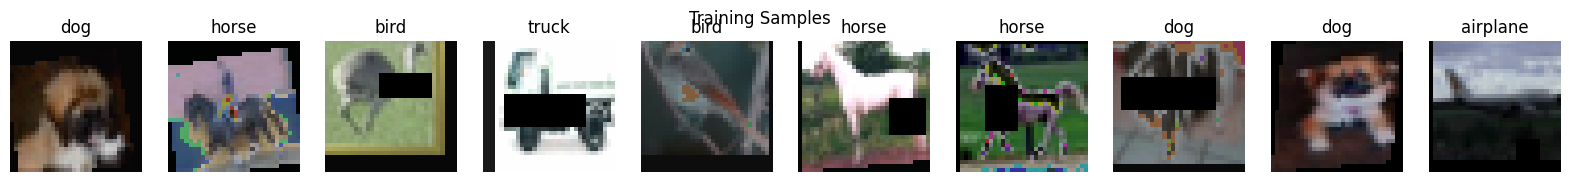

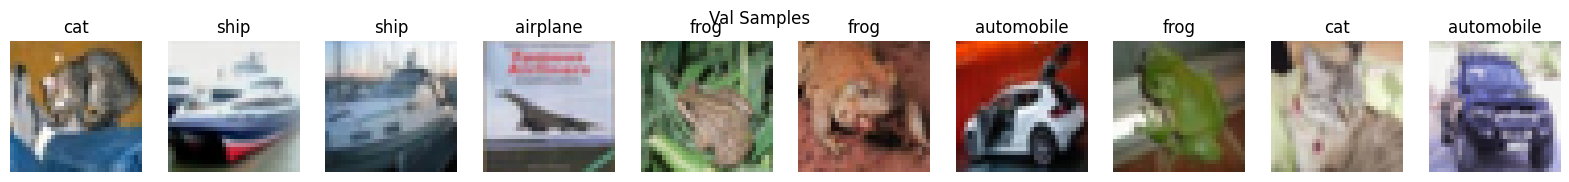

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
 AdaptiveAvgPool2d-9             [-1, 64, 1, 1]               0
           Linear-10                    [-1, 4]             256
             ReLU-11                    [-1, 4]               0
           Linear-12                   [-1, 64]             256
          Sigmoid-13                   [-1, 64]               0
          SEBlock-14           [-1, 64,

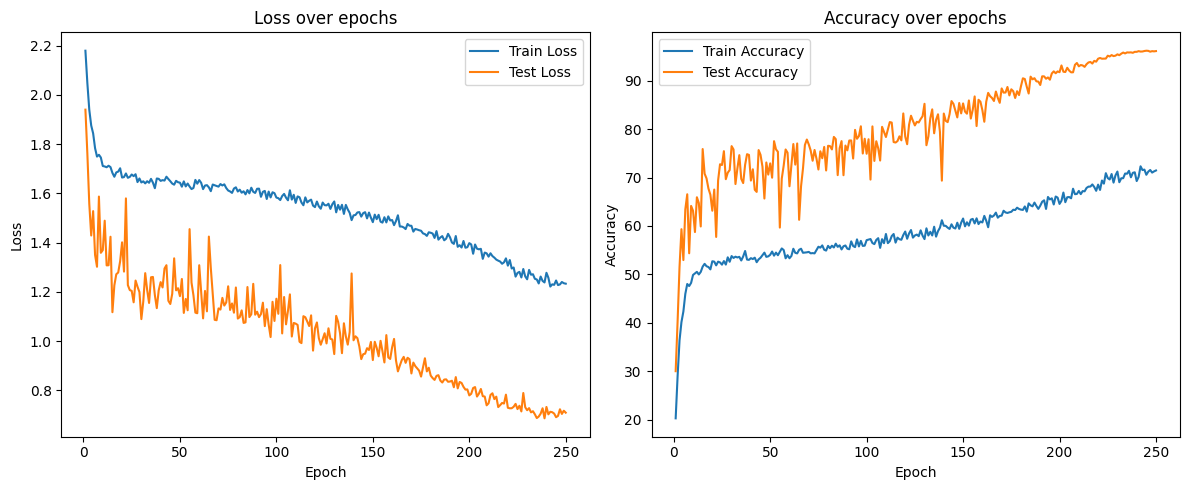

Model saved as resnet_cifar10.pth


In [77]:
def main():
    # Device configuration
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", device)
    train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    RandAugment(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.2)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

    val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    train_dataset = CIFAR10Dataset(train_data, train_labels, transform=train_transform)
    val_dataset = CIFAR10Dataset(test_data, test_labels, transform=val_transform)  # Using test as validation

    # Create the DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)

    
    # Visualize sample images from train and test sets
    show_sample_images(train_loader, LABELS, num_samples=10, title="Training Samples")
    show_sample_images(val_loader, LABELS, num_samples=10, title="Val Samples")
    
    # Perform EDA on the training dataset
    if hasattr(train_loader.dataset, 'targets'):
        eda_dataset(train_loader.dataset, classes)
    elif hasattr(train_loader.dataset, 'samples'):
        eda_dataset(train_loader.dataset, classes)

    
    # Build the model (here, ResNet20)
    use_se = True
    num_classes = len(LABELS)
    model = get_resnet_model(num_classes=10, depth=20, width_multiplier=4, use_se=use_se)
    model = model.to(device)
    summary(model, (3, 32, 32))
    
    total_params = count_parameters(model)
    print("Total trainable parameters:", total_params)
    if total_params > 5e6:
        print("Warning: The model exceeds 5 million parameters!")
    
    # Loss function and optimizer
    lr = 0.2
    weight_decay = 5e-4
    mixup_alpha  = 1.0
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    criterion = LabelSmoothingLoss(classes=10, smoothing=0.1)

    # MultiStep Scheduler
    # scheduler = MultiStepLR(optimizer, milestones=[50, 100, 150], gamma=0.1)

    #Cosine Annealing Scheduler, experimenting with this
    scheduler = CosineAnnealingLR(optimizer, T_max=250)
    
   
    epochs = 250
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    for epoch in range(1, epochs + 1):
        t_loss, t_acc = train(model, device, train_loader, criterion, optimizer, epoch, mixup_alpha)
        v_loss, v_acc = test(model, device, val_loader, criterion, epoch)
        scheduler.step()
        train_losses.append(t_loss)
        test_losses.append(v_loss)
        train_accs.append(t_acc)
        test_accs.append(v_acc)
    
    # Plot metrics
    plot_metrics(train_losses, test_losses, train_accs, test_accs)
    
    # Save the model checkpoint
    torch.save(model.state_dict(), "resnet_cifar10.pth")
    print("Model saved as resnet_cifar10.pth")

if __name__ == "__main__":
    main()

<ipython-input-78-a5023e34c7a9>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_cifar10.pth", map_location=device))


Normalized Confusion Matrix
[[0.969 0.001 0.013 0.003 0.    0.    0.    0.    0.011 0.003]
 [0.001 0.988 0.    0.    0.    0.    0.    0.    0.    0.011]
 [0.005 0.    0.961 0.011 0.008 0.01  0.002 0.002 0.001 0.   ]
 [0.005 0.001 0.012 0.92  0.004 0.044 0.008 0.004 0.001 0.001]
 [0.003 0.    0.012 0.013 0.951 0.009 0.003 0.009 0.    0.   ]
 [0.003 0.001 0.011 0.056 0.005 0.918 0.001 0.004 0.001 0.   ]
 [0.002 0.    0.007 0.011 0.    0.003 0.975 0.002 0.    0.   ]
 [0.    0.    0.003 0.006 0.004 0.006 0.    0.98  0.001 0.   ]
 [0.014 0.002 0.002 0.001 0.    0.    0.    0.    0.977 0.004]
 [0.002 0.017 0.001 0.003 0.    0.001 0.    0.    0.008 0.968]]


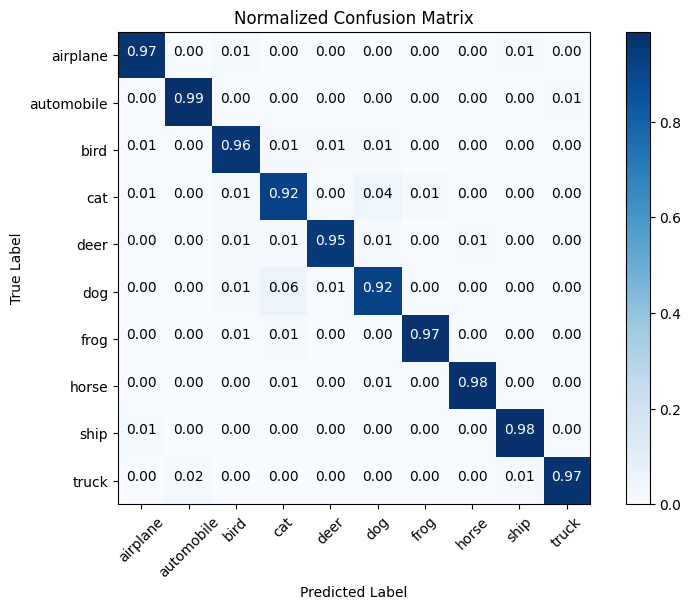

In [78]:
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
val_dataset = CIFAR10Dataset(test_data, test_labels, transform=val_transform)  # Using test as validation

val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

all_true = []
all_pred = []
model = get_resnet_model(num_classes=10, depth=20, width_multiplier=4)
model.load_state_dict(torch.load("resnet_cifar10.pth", map_location=device))
model.to(device)
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_true.extend(labels.numpy())
        all_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_true, all_pred)
plot_confusion_matrix(cm, classes=LABELS, normalize=True, title='Normalized Confusion Matrix')

In [79]:
def load_test_data(file_path):
    """Loads test data (without labels) from a pickle file."""
    batch = unpickle(file_path)
    # data = batch[b"data"].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    data = np.transpose(batch[b"data"], (0, 3, 1, 2)).astype(np.float32) / 255.0
    return data

In [80]:
# Custom Dataset for test data (without labels)
class CIFAR10TestDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        from PIL import Image  # local import for worker processes
        image = self.data[idx]
        image = Image.fromarray(np.transpose((image * 255).astype(np.uint8), (1, 2, 0)))
        if self.transform:
            image = self.transform(image)
        return image, idx  # return idx as the unique ID

In [81]:
# Define test transforms (same as your validation transform)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [82]:
def show_sample_test_images(loader, num_samples=4, title="Test Samples"):
    """Displays a few sample images from the test set along with their IDs."""
    data_iter = iter(loader)
    images, indices = next(data_iter)
    images = images[:num_samples]
    indices = indices[:num_samples]
    
    # Denormalize images for visualization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    images = images.numpy().transpose((0, 2, 3, 1))
    images = std * images + mean
    images = np.clip(images, 0, 1)
    
    plt.figure(figsize=(num_samples * 2, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(images[i])
        plt.title(f"ID: {indices[i].item()}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

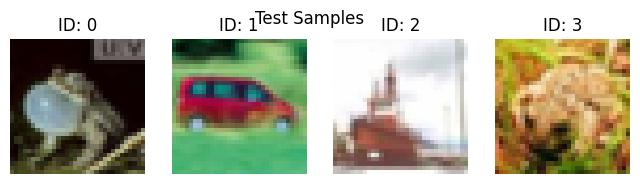

<ipython-input-83-a5810f72cb75>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_cifar10.pth", map_location=device))


Submission CSV saved as submission.csv


In [83]:
# Load test data from the provided pickle file
test_file = "/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl"
test_data = load_test_data(test_file)
test_dataset = CIFAR10TestDataset(test_data, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
# Visualize some sample test images
show_sample_test_images(test_loader, num_samples=4, title="Test Samples")
# --- Load the saved model and run inference ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = get_resnet_model(num_classes=10, depth=20, width_multiplier=4)
model.load_state_dict(torch.load("resnet_cifar10.pth", map_location=device))
model.to(device)
model.eval()

all_ids = []
all_preds = []
with torch.no_grad():
    for images, indices in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_ids.extend(indices.cpu().numpy())

# Map predicted indices to actual label names
pred_labels = all_preds

# Create a DataFrame for submission with 'ID' and 'label' columns
submission = pd.DataFrame({"ID": all_ids, "label": pred_labels})
submission.to_csv("submission.csv", index=False)
print("Submission CSV saved as submission.csv")


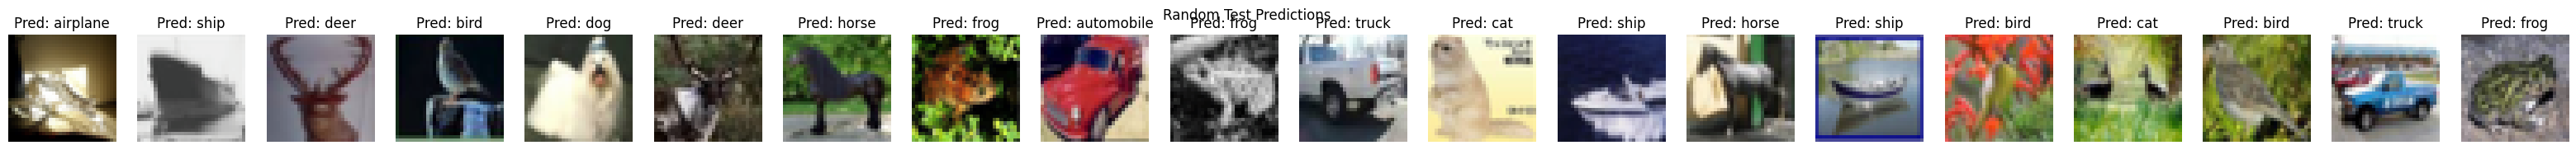

In [84]:
import random
def show_random_test_predictions(test_dataset, preds, num_samples=4, title="Random Test Predictions"):
    """Randomly sample test images and display them with their predicted label value."""
    indices = random.sample(range(len(test_dataset)), num_samples)
    plt.figure(figsize=(num_samples * 2, 2))
    for i, idx in enumerate(indices):
        image, _ = test_dataset[idx]
        # Denormalize for visualization
        img = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {LABELS[preds[idx]]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_random_test_predictions(test_dataset, pred_labels, num_samples=20, title="Random Test Predictions")